## NBA STATS ANALYSIS AND MVP PREDICTION
    by Aziz Bohra and Justin Reagle

### Motivation for work

We wanted to look at sports statistics to better understand what makes a player "the best." We decided to look at a collection of statisitcs for the NBA that we could model to dive deeper into what makes an NBA player an MVP.

All the time we see sports commentators and analysts tracking the MVP race in different leagues and we wanted to see if we could do a prediction of these MVPs ourselves

Specifically we wanted to answer the questions of:

1. What stats are the most important for MVP candidates?
2. How can we model the data to predict the MVPs?
3. Could we apply this method to future data? Other sports?

### Importing Essential Modules

In [ ]:
#essentials
import os
import numpy as np
import pandas as pd
import scipy as sp
import pickle
import warnings
warnings.filterwarnings('ignore')

#visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#tools/metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tqdm.notebook import tqdm

#modeling
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

#pandas show all columns
pd.set_option('display.max_columns', None)

---

### Read Data

This dataset is a combination of four different stats for each player; the regular season stats, the advanced season stats, the team's stats, and the MVP voting stats.

In [ ]:
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
main_df = pd.read_csv('/content/drive/MyDrive/NBA_Dataset.csv')
main_df = main_df.fillna(0)
main_df.head()

,season,player,pos,age,team_id,g,gs,mp_per_g,fg_per_g,fga_per_g,fg_pct,fg3_per_g,fg3a_per_g,fg3_pct,fg2_per_g,fg2a_per_g,fg2_pct,efg_pct,ft_per_g,fta_per_g,ft_pct,orb_per_g,drb_per_g,trb_per_g,ast_per_g,stl_per_g,blk_per_g,tov_per_g,pf_per_g,pts_per_g,mp,per,ts_pct,fg3a_per_fga_pct,fta_per_fga_pct,orb_pct,drb_pct,trb_pct,ast_pct,stl_pct,blk_pct,tov_pct,usg_pct,ows,dws,ws,ws_per_48,obpm,dbpm,bpm,vorp,award_share,mov,mov_adj,win_loss_pct
0,1982,Kareem Abdul-Jabbar,C,34,LAL,76,76,35.2,9.9,17.1,0.579,0.0,0.0,0.000,9.9,17.1,0.580,0.579,4.1,5.8,0.706,2.3,6.4,8.7,3.0,0.8,2.7,3.0,2.9,23.9,2677,23.4,0.608,0.002,0.340,7.3,19.1,13.4,11.9,1.1,4.1,13.3,25.6,6.9,3.9,10.7,0.192,3.8,1.2,5.0,4.7,0.045,4.87,4.37,0.695
1,1982,Alvan Adams,C,27,PHO,79,75,30.3,6.4,13.0,0.494,0.0,0.0,0.000,6.4,13.0,0.494,0.494,2.3,2.9,0.781,1.7,5.7,7.4,4.5,1.4,1.0,2.5,3.4,15.1,2393,18.6,0.529,0.001,0.227,6.6,20.2,13.6,22.1,2.3,1.9,14.8,22.8,2.5,4.7,7.2,0.144,1.4,2.2,3.6,3.4,0.000,3.45,3.05,0.561
2,1982,Mark Aguirre,SF,22,DAL,51,20,28.8,7.5,16.1,0.465,0.5,1.4,0.352,7.0,14.7,0.475,0.480,3.3,4.8,0.680,1.7,3.1,4.9,3.2,0.7,0.4,2.6,3.0,18.7,1468,17.3,0.514,0.087,0.301,6.7,12.9,9.7,18.6,1.2,0.9,12.7,29.8,1.0,0.8,1.9,0.061,2.3,-1.6,0.7,1.0,0.000,-4.43,-4.48,0.341
3,1982,Danny Ainge,SG,22,BOS,53,1,10.6,1.5,4.2,0.357,0.1,0.3,0.294,1.4,3.8,0.363,0.369,1.1,1.2,0.862,0.5,0.6,1.1,1.6,0.7,0.1,1.0,1.6,4.1,564,10.1,0.439,0.077,0.294,5.0,5.9,5.5,19.7,3.1,0.3,17.5,21.5,-0.3,0.8,0.5,0.042,-3.7,1.0,-2.7,-0.1,0.000,6.38,6.35,0.768
4,1982,Tiny Archibald,PG,33,BOS,68,51,31.9,4.5,9.6,0.472,0.1,0.2,0.375,4.4,9.4,0.475,0.477,3.5,4.6,0.747,0.4,1.3,1.7,8.0,0.8,0.0,2.6,1.9,12.6,2167,14.3,0.542,0.025,0.485,1.3,4.5,2.9,31.9,1.1,0.1,18.4,17.9,3.4,1.8,5.2,0.115,1.4,-1.3,0.1,1.1,0.000,6.38,6.35,0.768


---

### Data Preprocessing

Since the primary aim of this project is to most accurately predict the most valuable player of the NBA in a given year, we need to create an additional boolean value column that denotes which player won the MVP for the years recorded in the dataset. This will make it easier to cross check if our predictive results were accurate while testing.

In [ ]:
mvps = main_df.groupby(by = "season").max('award_share')
mvps["was_mvp"] = True
main_df = main_df.merge(mvps[["award_share", "was_mvp"]], on = ["season", "award_share"], how = "left")
main_df["was_mvp"] = main_df["was_mvp"].fillna(value = False)

In [ ]:
main_df.head()

,season,player,pos,age,team_id,g,gs,mp_per_g,fg_per_g,fga_per_g,fg_pct,fg3_per_g,fg3a_per_g,fg3_pct,fg2_per_g,fg2a_per_g,fg2_pct,efg_pct,ft_per_g,fta_per_g,ft_pct,orb_per_g,drb_per_g,trb_per_g,ast_per_g,stl_per_g,blk_per_g,tov_per_g,pf_per_g,pts_per_g,mp,per,ts_pct,fg3a_per_fga_pct,fta_per_fga_pct,orb_pct,drb_pct,trb_pct,ast_pct,stl_pct,blk_pct,tov_pct,usg_pct,ows,dws,ws,ws_per_48,obpm,dbpm,bpm,vorp,award_share,mov,mov_adj,win_loss_pct,was_mvp
0,1982,Kareem Abdul-Jabbar,C,34,LAL,76,76,35.2,9.9,17.1,0.579,0.0,0.0,0.000,9.9,17.1,0.580,0.579,4.1,5.8,0.706,2.3,6.4,8.7,3.0,0.8,2.7,3.0,2.9,23.9,2677,23.4,0.608,0.002,0.340,7.3,19.1,13.4,11.9,1.1,4.1,13.3,25.6,6.9,3.9,10.7,0.192,3.8,1.2,5.0,4.7,0.045,4.87,4.37,0.695,False
1,1982,Alvan Adams,C,27,PHO,79,75,30.3,6.4,13.0,0.494,0.0,0.0,0.000,6.4,13.0,0.494,0.494,2.3,2.9,0.781,1.7,5.7,7.4,4.5,1.4,1.0,2.5,3.4,15.1,2393,18.6,0.529,0.001,0.227,6.6,20.2,13.6,22.1,2.3,1.9,14.8,22.8,2.5,4.7,7.2,0.144,1.4,2.2,3.6,3.4,0.000,3.45,3.05,0.561,False
2,1982,Mark Aguirre,SF,22,DAL,51,20,28.8,7.5,16.1,0.465,0.5,1.4,0.352,7.0,14.7,0.475,0.480,3.3,4.8,0.680,1.7,3.1,4.9,3.2,0.7,0.4,2.6,3.0,18.7,1468,17.3,0.514,0.087,0.301,6.7,12.9,9.7,18.6,1.2,0.9,12.7,29.8,1.0,0.8,1.9,0.061,2.3,-1.6,0.7,1.0,0.000,-4.43,-4.48,0.341,False
3,1982,Danny Ainge,SG,22,BOS,53,1,10.6,1.5,4.2,0.357,0.1,0.3,0.294,1.4,3.8,0.363,0.369,1.1,1.2,0.862,0.5,0.6,1.1,1.6,0.7,0.1,1.0,1.6,4.1,564,10.1,0.439,0.077,0.294,5.0,5.9,5.5,19.7,3.1,0.3,17.5,21.5,-0.3,0.8,0.5,0.042,-3.7,1.0,-2.7,-0.1,0.000,6.38,6.35,0.768,False
4,1982,Tiny Archibald,PG,33,BOS,68,51,31.9,4.5,9.6,0.472,0.1,0.2,0.375,4.4,9.4,0.475,0.477,3.5,4.6,0.747,0.4,1.3,1.7,8.0,0.8,0.0,2.6,1.9,12.6,2167,14.3,0.542,0.025,0.485,1.3,4.5,2.9,31.9,1.1,0.1,18.4,17.9,3.4,1.8,5.2,0.115,1.4,-1.3,0.1,1.1,0.000,6.38,6.35,0.768,False


Here we don't just add new features but we also remove ones that are repetitive or add no value. On conducting some simple EDA we can see that several of the statistics within the data set can be derived from combinations of multiple stats. For example, we can derive fg_per_g by multiplying fga_per_g with fg_pct.

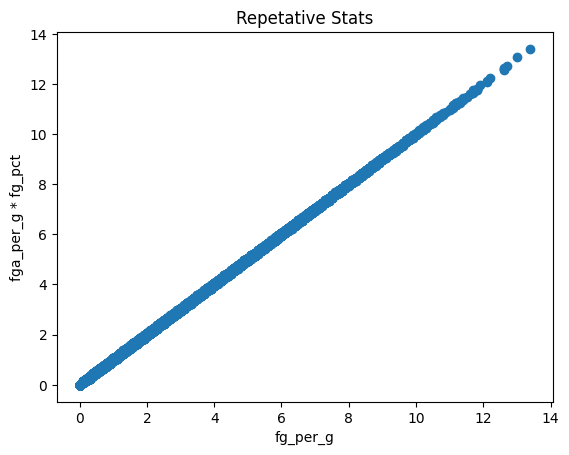

array([[1.        , 0.99990689],
       [0.99990689, 1.        ]])

In [ ]:
plt.scatter(main_df["fg_per_g"], main_df["fga_per_g"]*main_df["fg_pct"])
plt.xlabel("fg_per_g")
plt.ylabel("fga_per_g * fg_pct")
plt.title("Repetative Stats")
plt.show()
np.corrcoef(main_df["fg_per_g"], main_df["fga_per_g"]*main_df["fg_pct"])

In [ ]:
main_df = main_df.drop(columns = ["fg_per_g", "fg3_per_g", "fg2_per_g", "ft_per_g", "trb_per_g"], axis = 1)

---

### Exploratory Data Analysis

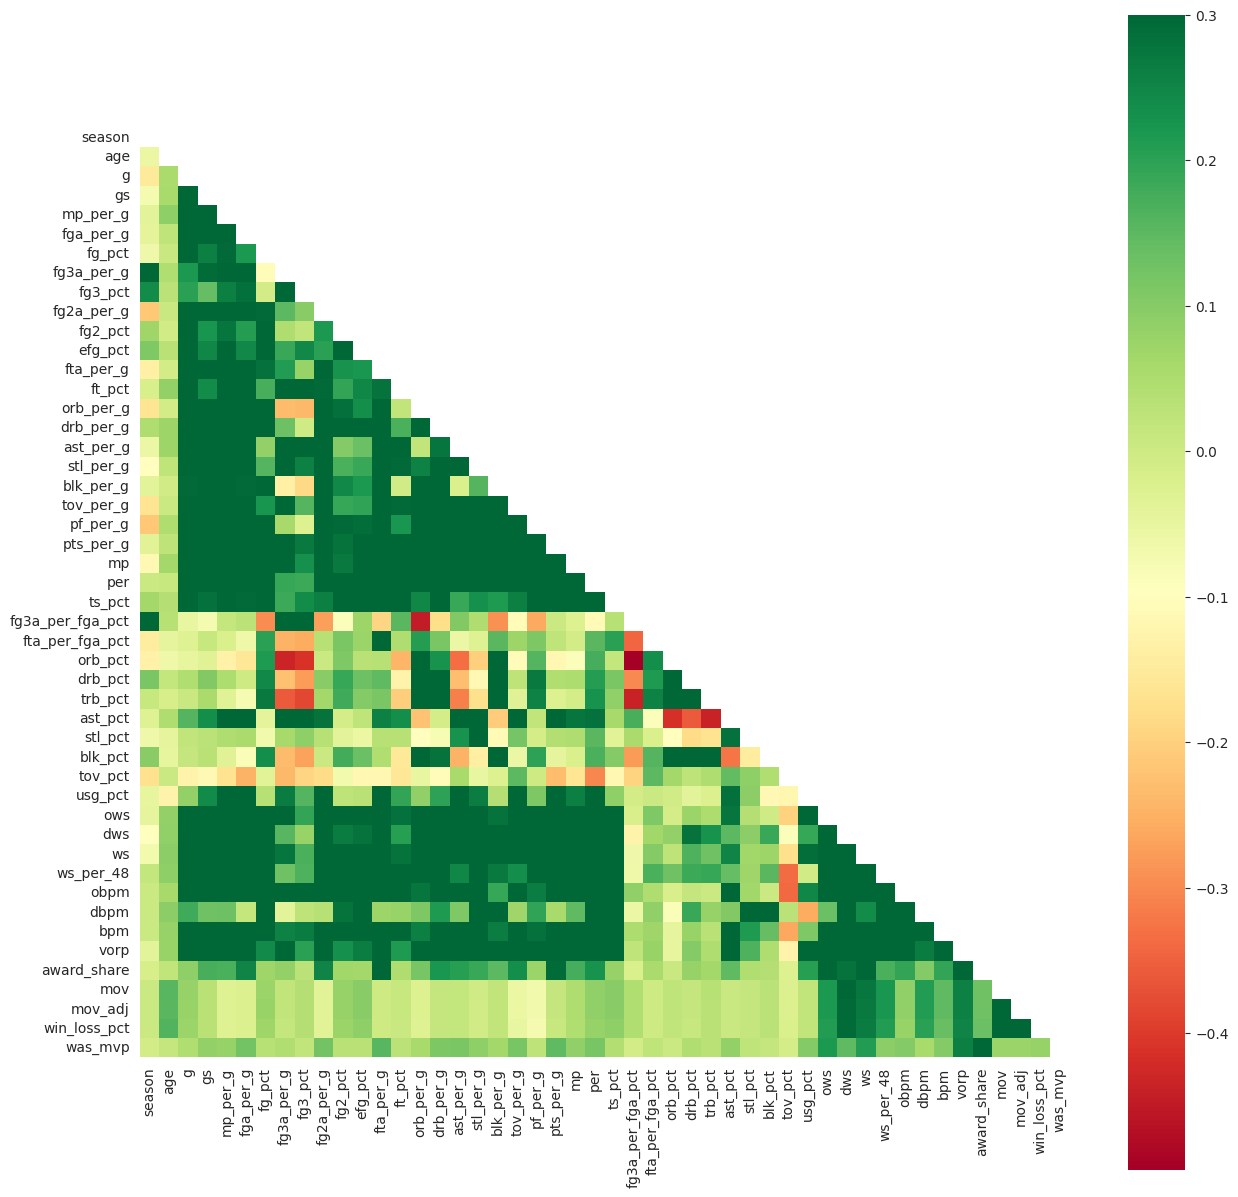

In [ ]:
# @title Correlation Heat Map

#correlations of each features
corr_matrix = main_df.corr()

#plot heat map
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 15))
    ax = sns.heatmap(corr_matrix, mask=mask, vmax=.3, square=True,cmap="RdYlGn")

---

### Further EDA

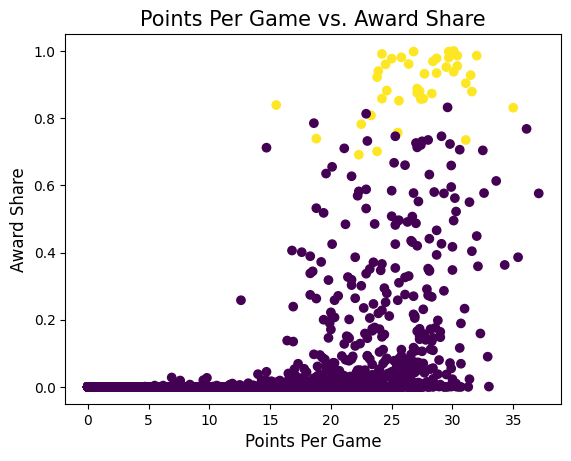

In [ ]:
# @title Points Per Game vs. Award Share
plt.scatter(main_df['pts_per_g'], main_df['award_share'], c = main_df['was_mvp'])
plt.title('Points Per Game vs. Award Share', fontsize=15, c='black')
plt.xlabel('Points Per Game', fontsize=12)
plt.ylabel('Award Share', fontsize = 12)
plt.show()

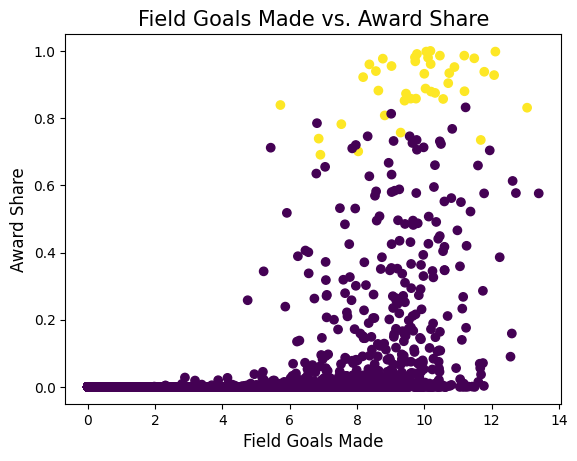

In [ ]:
# @title Field Goals Made vs. Award Share
plt.scatter(main_df["fga_per_g"]*main_df["fg_pct"] ,main_df['award_share'], c = main_df['was_mvp'])
plt.title('Field Goals Made vs. Award Share', fontsize=15, c='black')
plt.xlabel('Field Goals Made', fontsize=12)
plt.ylabel('Award Share', fontsize = 12)
plt.show()

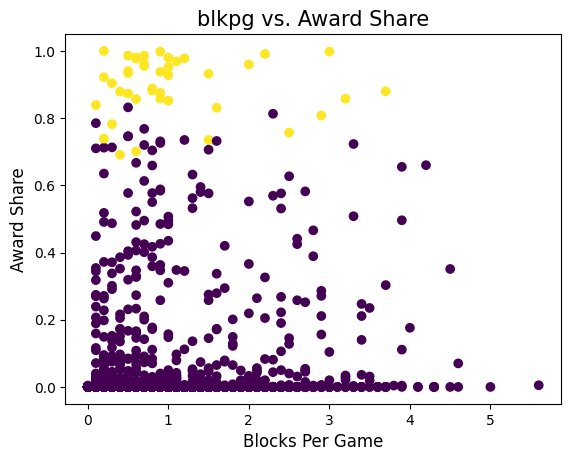

In [ ]:
# @title Blocks per Game vs. Award Share
plt.scatter(main_df['blk_per_g'] ,main_df['award_share'], c = main_df['was_mvp'])
plt.title('blkpg vs. Award Share', fontsize=15, c='black')
plt.xlabel('Blocks Per Game', fontsize=12)
plt.ylabel('Award Share', fontsize = 12)
plt.show()

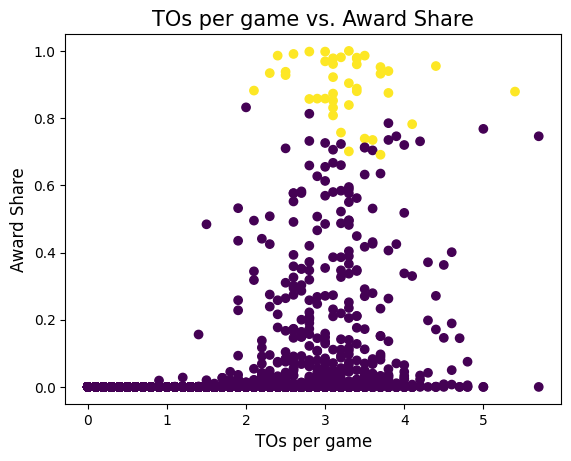

In [ ]:
# @title Turnovers per Game vs. Award Share
plt.scatter(main_df['tov_per_g'] ,main_df['award_share'], c = main_df['was_mvp'])
plt.title('TOs per game vs. Award Share', fontsize=15, c='black')
plt.xlabel('TOs per game', fontsize=12)
plt.ylabel('Award Share', fontsize = 12)
plt.show()

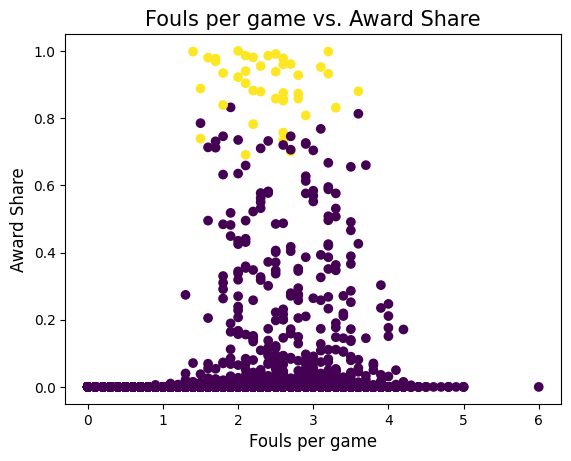

In [ ]:
# @title Fouls per Game vs. Award Share
plt.scatter(main_df['pf_per_g'] ,main_df['award_share'], c = main_df['was_mvp'])
plt.title('Fouls per game vs. Award Share', fontsize=15, c='black')
plt.xlabel('Fouls per game', fontsize=12)
plt.ylabel('Award Share', fontsize = 12)
plt.show()

As we can see from these scatterplots, the MVP's of the past 40 years are generally trend towards having higher value stats, regardless of what that stat actually is. It might be a good idea to think that MVPs are players that trend towards the highest ball possession time. This would explain why MVPs still average about 3 turnovers per game and about 2.5 fouls per game.

In [ ]:
mvp_df = main_df[main_df['was_mvp'] == 1]

In [ ]:
print(mvp_df['pos'].value_counts())

PF    11
PG     9
SG     8
C      7
SF     6
Name: pos, dtype: int64


In [ ]:
print(mvp_df.groupby('pos')['player'].value_counts())

pos  player               
C    Moses Malone             2
     Nikola Jokić             2
     David Robinson           1
     Hakeem Olajuwon          1
     Shaquille O'Neal         1
PF   Giannis Antetokounmpo    2
     Karl Malone              2
     Tim Duncan               2
     Charles Barkley          1
     Dirk Nowitzki            1
     Kevin Garnett            1
     Larry Bird               1
     LeBron James             1
PG   Magic Johnson            3
     Stephen Curry            2
     Steve Nash               2
     Derrick Rose             1
     Russell Westbrook        1
SF   LeBron James             3
     Larry Bird               2
     Kevin Durant             1
SG   Michael Jordan           5
     Allen Iverson            1
     James Harden             1
     Kobe Bryant              1
Name: player, dtype: int64


In [ ]:
main_df[main_df['was_mvp'] == 0]['pts_per_g'].describe()

count    17656.000000
mean         8.372372
std          6.039227
min          0.000000
25%          3.600000
50%          6.900000
75%         11.900000
max         37.100000
Name: pts_per_g, dtype: float64

In [ ]:
mvp_df['pts_per_g'].describe()

count    41.00000
mean     27.00000
std       3.74533
min      15.50000
25%      24.50000
50%      27.30000
75%      29.70000
max      35.00000
Name: pts_per_g, dtype: float64

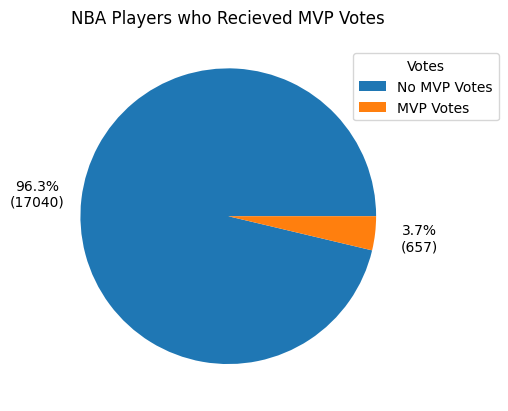

In [ ]:
from collections import Counter

classes = main_df["award_share"] > 0
infoDf = main_df[["player", "pos", "team_id"]]
dataDf = main_df.drop(["player", "pos", "team_id"], axis = 1)

def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n({:d})".format(pct, absolute)

fig, ax = plt.subplots()

wedges, texts, autotexts = ax.pie(classes.value_counts(),
       autopct = lambda pct: func(pct, classes.value_counts()),
       pctdistance = 1.3)

ax.set_title("NBA Players who Recieved MVP Votes")
ax.legend(["No MVP Votes", "MVP Votes"],
          title="Votes",
          loc = 'center right',
           bbox_to_anchor=(1.25, 0.85))

plt.show()

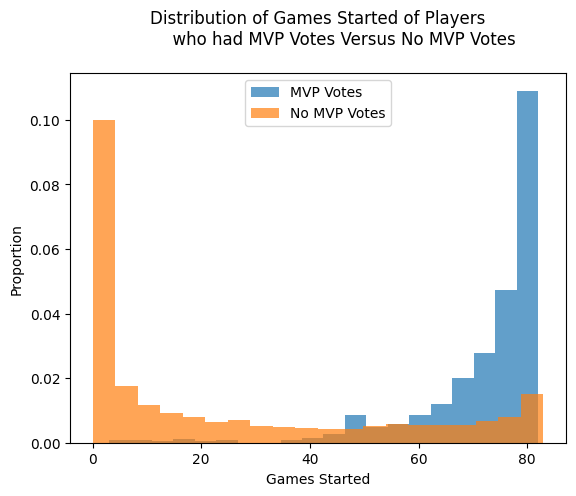

In [ ]:
mvpShares = main_df[main_df["award_share"] > 0]
nonMvpShares = main_df[main_df["award_share"] == 0]

plt.hist(mvpShares["gs"], bins = 20, alpha = 0.7, density=True, label = "MVP Votes")
plt.hist(nonMvpShares["gs"], bins = 20, alpha = 0.7, density=True, label = "No MVP Votes")
plt.ylabel("Proportion")
plt.xlabel("Games Started")
plt.title("""Distribution of Games Started of Players
          who had MVP Votes Versus No MVP Votes
          """)
plt.legend()
plt.show()

It is important to figure out what the majority and minority classes of a dataset are when it comes to imbalanced data. One way to do this is through undersampling. A good way for us to undersample the majority class is by removing players that have an extremely low chance of receiving votes. For example, we could remove players who score very few points, players who start very few games, and players that play very few minutes.

In [ ]:
mvpShares[mvpShares["gs"] < 20][["season", "player", "g", "gs", "pts_per_g", 'award_share']].reset_index(drop = True)

,season,player,g,gs,pts_per_g,award_share
0,1982,Michael Cooper,76,14,11.9,0.004
1,1991,Kevin McHale,68,10,18.4,0.001
2,1992,Detlef Schrempf,80,4,17.3,0.001
3,1995,Michael Jordan,17,17,26.9,0.011
4,1996,Magic Johnson,32,9,14.6,0.007
5,1999,Darrell Armstrong,50,15,13.8,0.002
6,1999,Rasheed Wallace,49,18,12.8,0.001
7,2021,Derrick Rose,50,3,14.7,0.010


In [ ]:
main_df = main_df[main_df["gs"] > 20]
main_df = main_df.reset_index(drop = True)
len(main_df)

7328

When we take out the players who played less than 20 games we then reduce the data size to 7,328, which is roughly 2/5 of our original data set. Since we only took out 8 players who received MVP votes, we then removed 10,369 players that didn't start enough games to be considered MVP.

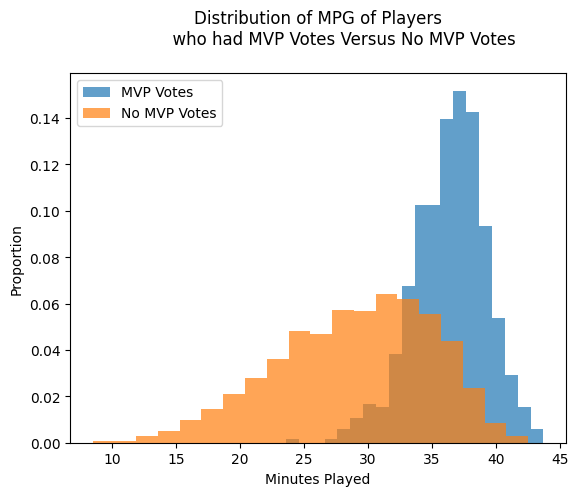

The cutoff is 27.890 minutes per game


In [ ]:
mvpShares = main_df[main_df["award_share"] > 0]
nonMvpShares = main_df[main_df["award_share"] == 0]

plt.hist(mvpShares["mp_per_g"], bins = 20, alpha = 0.7, density=True, label = "MVP Votes")
plt.hist(nonMvpShares["mp_per_g"], bins = 20, alpha = 0.7, density=True, label = "No MVP Votes")
plt.ylabel("Proportion")
plt.xlabel("Minutes Played")
plt.title("""Distribution of MPG of Players
          who had MVP Votes Versus No MVP Votes
          """)
plt.legend()
plt.show()

mp_cutoff = mvpShares["mp_per_g"].mean() - 3*mvpShares["mp_per_g"].std()
print(f"The cutoff is {mp_cutoff:.3f} minutes per game")

> To be an MVP, it seems logical that you get significant playing time on the court. Using this ideology, we can remove players from the dataset that have little playing time. By doing this we hope to undersample the majority class and reduce the amount of unnecessary data.
To identify a cutoff, We will use the third standard deviation from the mean minutes played per game by players who received MVP votes. This ended up being 27.581 points

### Feature Selection: The Boruta Method

We are using the Bortua method to find which features of our data set are the most important when deciding which tuples are MVPs

This algorithm uses a Random Forest Classifier to assign a 'variable importance' to each feature, then keeping the features that fall higher than the most important shadow features, which are just copies of our original features

In [ ]:
fs_df = main_df.drop(columns = ["season", "player", "pos", "team_id"], axis = 1)
fs_df.head()

,age,g,gs,mp_per_g,fga_per_g,fg_pct,fg3a_per_g,fg3_pct,fg2a_per_g,fg2_pct,efg_pct,fta_per_g,ft_pct,orb_per_g,drb_per_g,ast_per_g,stl_per_g,blk_per_g,tov_per_g,pf_per_g,pts_per_g,mp,per,ts_pct,fg3a_per_fga_pct,fta_per_fga_pct,orb_pct,drb_pct,trb_pct,ast_pct,stl_pct,blk_pct,tov_pct,usg_pct,ows,dws,ws,ws_per_48,obpm,dbpm,bpm,vorp,award_share,mov,mov_adj,win_loss_pct,was_mvp
0,34,76,76,35.2,17.1,0.579,0.0,0.000,17.1,0.580,0.579,5.8,0.706,2.3,6.4,3.0,0.8,2.7,3.0,2.9,23.9,2677,23.4,0.608,0.002,0.340,7.3,19.1,13.4,11.9,1.1,4.1,13.3,25.6,6.9,3.9,10.7,0.192,3.8,1.2,5.0,4.7,0.045,4.87,4.37,0.695,False
1,27,79,75,30.3,13.0,0.494,0.0,0.000,13.0,0.494,0.494,2.9,0.781,1.7,5.7,4.5,1.4,1.0,2.5,3.4,15.1,2393,18.6,0.529,0.001,0.227,6.6,20.2,13.6,22.1,2.3,1.9,14.8,22.8,2.5,4.7,7.2,0.144,1.4,2.2,3.6,3.4,0.000,3.45,3.05,0.561,False
2,33,68,51,31.9,9.6,0.472,0.2,0.375,9.4,0.475,0.477,4.6,0.747,0.4,1.3,8.0,0.8,0.0,2.6,1.9,12.6,2167,14.3,0.542,0.025,0.485,1.3,4.5,2.9,31.9,1.1,0.1,18.4,17.9,3.4,1.8,5.2,0.115,1.4,-1.3,0.1,1.1,0.000,6.38,6.35,0.768,False
3,27,79,79,37.3,16.5,0.475,0.3,0.409,16.3,0.476,0.479,3.6,0.830,1.7,6.3,3.2,1.7,0.3,1.5,2.6,18.8,2946,17.9,0.519,0.017,0.217,5.1,18.1,11.7,13.1,2.2,0.4,7.7,22.0,4.1,5.3,9.4,0.154,1.5,1.7,3.2,3.9,0.000,0.88,1.06,0.524,False
4,30,82,38,24.6,8.7,0.469,0.1,0.333,8.6,0.470,0.471,3.3,0.629,2.1,3.2,1.4,0.8,0.7,1.8,3.3,10.2,2016,12.7,0.505,0.008,0.375,9.7,14.4,12.1,8.1,1.5,1.7,15.2,20.2,0.2,2.7,2.9,0.069,-2.0,-0.3,-2.3,-0.1,0.000,0.00,0.00,0.500,False


In [ ]:
fs_df["was_mvp"] = fs_df["was_mvp"].astype(int)
y = fs_df['was_mvp']
x = fs_df.drop("was_mvp", axis = 1)

In [ ]:
for col in x.columns:
  x[f"shadow_{col}"] = x[col].sample(frac=1).reset_index(drop = True)

x.head()

,age,g,gs,mp_per_g,fga_per_g,fg_pct,fg3a_per_g,fg3_pct,fg2a_per_g,fg2_pct,efg_pct,fta_per_g,ft_pct,orb_per_g,drb_per_g,ast_per_g,stl_per_g,blk_per_g,tov_per_g,pf_per_g,pts_per_g,mp,per,ts_pct,fg3a_per_fga_pct,fta_per_fga_pct,orb_pct,drb_pct,trb_pct,ast_pct,stl_pct,blk_pct,tov_pct,usg_pct,ows,dws,ws,ws_per_48,obpm,dbpm,bpm,vorp,award_share,mov,mov_adj,win_loss_pct,shadow_age,shadow_g,shadow_gs,shadow_mp_per_g,shadow_fga_per_g,shadow_fg_pct,shadow_fg3a_per_g,shadow_fg3_pct,shadow_fg2a_per_g,shadow_fg2_pct,shadow_efg_pct,shadow_fta_per_g,shadow_ft_pct,shadow_orb_per_g,shadow_drb_per_g,shadow_ast_per_g,shadow_stl_per_g,shadow_blk_per_g,shadow_tov_per_g,shadow_pf_per_g,shadow_pts_per_g,shadow_mp,shadow_per,shadow_ts_pct,shadow_fg3a_per_fga_pct,shadow_fta_per_fga_pct,shadow_orb_pct,shadow_drb_pct,shadow_trb_pct,shadow_ast_pct,shadow_stl_pct,shadow_blk_pct,shadow_tov_pct,shadow_usg_pct,shadow_ows,shadow_dws,shadow_ws,shadow_ws_per_48,shadow_obpm,shadow_dbpm,shadow_bpm,shadow_vorp,shadow_award_share,shadow_mov,shadow_mov_adj,shadow_win_loss_pct
0,34,76,76,35.2,17.1,0.579,0.0,0.000,17.1,0.580,0.579,5.8,0.706,2.3,6.4,3.0,0.8,2.7,3.0,2.9,23.9,2677,23.4,0.608,0.002,0.340,7.3,19.1,13.4,11.9,1.1,4.1,13.3,25.6,6.9,3.9,10.7,0.192,3.8,1.2,5.0,4.7,0.045,4.87,4.37,0.695,26,49,71,39.0,8.9,0.419,2.1,0.276,10.0,0.491,0.407,2.4,0.813,1.2,1.4,2.8,0.3,0.1,1.0,1.9,19.5,2315,12.3,0.593,0.143,0.153,2.2,20.0,12.7,14.0,1.3,1.9,17.5,19.2,2.6,0.7,6.7,-0.033,-1.1,-1.5,10.9,1.3,0.0,5.22,3.58,0.500
1,27,79,75,30.3,13.0,0.494,0.0,0.000,13.0,0.494,0.494,2.9,0.781,1.7,5.7,4.5,1.4,1.0,2.5,3.4,15.1,2393,18.6,0.529,0.001,0.227,6.6,20.2,13.6,22.1,2.3,1.9,14.8,22.8,2.5,4.7,7.2,0.144,1.4,2.2,3.6,3.4,0.000,3.45,3.05,0.561,35,82,25,36.2,13.9,0.389,2.1,0.000,9.8,0.465,0.493,3.9,0.857,0.8,3.2,2.9,0.4,0.0,3.2,1.7,17.9,1507,13.1,0.522,0.294,0.205,11.6,9.5,5.2,36.7,2.6,1.1,13.6,22.2,1.6,1.6,7.0,0.104,1.7,-0.2,1.3,3.2,0.0,-1.37,2.34,0.524
2,33,68,51,31.9,9.6,0.472,0.2,0.375,9.4,0.475,0.477,4.6,0.747,0.4,1.3,8.0,0.8,0.0,2.6,1.9,12.6,2167,14.3,0.542,0.025,0.485,1.3,4.5,2.9,31.9,1.1,0.1,18.4,17.9,3.4,1.8,5.2,0.115,1.4,-1.3,0.1,1.1,0.000,6.38,6.35,0.768,23,80,71,34.4,9.7,0.455,7.4,0.500,10.3,0.556,0.548,2.8,0.580,0.4,5.1,2.9,0.6,0.1,2.3,2.4,24.2,1923,14.5,0.547,0.176,0.200,3.1,15.8,6.9,18.6,1.8,1.0,15.4,24.8,2.2,0.4,6.7,0.062,-1.3,1.1,2.7,3.6,0.0,-2.33,0.64,0.610
3,27,79,79,37.3,16.5,0.475,0.3,0.409,16.3,0.476,0.479,3.6,0.830,1.7,6.3,3.2,1.7,0.3,1.5,2.6,18.8,2946,17.9,0.519,0.017,0.217,5.1,18.1,11.7,13.1,2.2,0.4,7.7,22.0,4.1,5.3,9.4,0.154,1.5,1.7,3.2,3.9,0.000,0.88,1.06,0.524,31,81,30,29.0,10.6,0.364,0.2,0.353,6.5,0.446,0.478,5.2,0.698,2.7,5.1,1.5,0.5,1.8,3.2,3.0,20.5,2344,16.8,0.544,0.292,0.417,1.6,4.4,8.8,2.2,0.6,0.7,12.8,28.5,5.9,3.6,2.7,0.169,-3.2,-2.0,-6.7,4.3,0.0,5.34,0.27,0.793
4,30,82,38,24.6,8.7,0.469,0.1,0.333,8.6,0.470,0.471,3.3,0.629,2.1,3.2,1.4,0.8,0.7,1.8,3.3,10.2,2016,12.7,0.505,0.008,0.375,9.7,14.4,12.1,8.1,1.5,1.7,15.2,20.2,0.2,2.7,2.9,0.069,-2.0,-0.3,-2.3,-0.1,0.000,0.00,0.00,0.500,22,43,40,27.9,14.1,0.463,0.0,0.388,9.4,0.531,0.514,2.2,0.814,2.1,3.2,1.0,0.6,0.7,2.1,1.8,8.6,1965,15.5,0.540,0.020,0.413,5.4,18.3,13.2,4.9,1.2,1.0,12.9,21.3,11.0,1.9,5.3,0.050,-1.3,1.4,2.9,0.5,0.0,-8.18,-0.94,0.317


In [ ]:
def get_important_features(X, y):
  # Initiliaze Random Forest CLassifier
  rf = RandomForestClassifier(max_depth=20)
  # Fit Random Forest on provided data
  rf.fit(X,y)
  # Create dictionary of feature importances
  importances = {feature_name: f_importance for feature_name, f_importance in zip(X.columns, rf.feature_importances_)}
  # Isolate importances of Shadow features
  only_shadow_feat_importance = {key:value for key,value in importances.items() if "shadow" in key}
  # get importance level of most important shadow feature
  highest_shadow_feature = list(dict(sorted(only_shadow_feat_importance.items(), key=lambda item: item[1], reverse=True)).values())[0]
  # get original feature which fulfill boruta selection criteria
  selected_features = [key for key, value in importances.items() if value > highest_shadow_feature]
  return selected_features

In [ ]:
TRIALS = 50
feature_hits = {i:0 for i in fs_df.columns}
for _ in tqdm(range(TRIALS)):
    imp_features = get_important_features(x, y)
    for key, _ in feature_hits.items():
      if key in imp_features: feature_hits[key] += 1

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
sorted_feature_hits = sorted(feature_hits.items(), key=lambda x:x[1], reverse = True)
print(sorted_feature_hits)

[('per', 50), ('ows', 50), ('ws', 50), ('ws_per_48', 50), ('obpm', 50), ('bpm', 50), ('vorp', 50), ('award_share', 50), ('mov_adj', 50), ('win_loss_pct', 50), ('mov', 48), ('pts_per_g', 46), ('dws', 40), ('fg2a_per_g', 35), ('fga_per_g', 34), ('usg_pct', 29), ('fta_per_g', 24), ('dbpm', 24), ('mp', 14), ('tov_per_g', 11), ('mp_per_g', 10), ('orb_per_g', 9), ('ast_pct', 9), ('ast_per_g', 8), ('drb_per_g', 4), ('fg3_pct', 2), ('age', 1), ('pf_per_g', 1), ('fg3a_per_fga_pct', 1), ('trb_pct', 1), ('tov_pct', 1), ('g', 0), ('gs', 0), ('fg_pct', 0), ('fg3a_per_g', 0), ('fg2_pct', 0), ('efg_pct', 0), ('ft_pct', 0), ('stl_per_g', 0), ('blk_per_g', 0), ('ts_pct', 0), ('fta_per_fga_pct', 0), ('orb_pct', 0), ('drb_pct', 0), ('stl_pct', 0), ('blk_pct', 0), ('was_mvp', 0)]


In [ ]:
pmf = [sp.stats.binom.pmf(x, TRIALS, .5) for x in range(TRIALS + 1)]

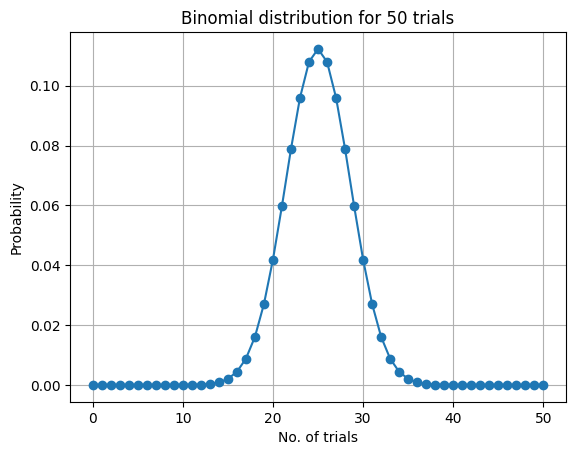

In [ ]:
# plot the binomial distribution
plt.plot([i for i in range(TRIALS + 1)], pmf,"-o")
plt.title(f"Binomial distribution for {TRIALS} trials")
plt.xlabel("No. of trials")
plt.ylabel("Probability")
plt.grid(True)

In [ ]:
# trails_in_green_zone
def get_tail_items(pmf):
  total = 0
  for i, x in enumerate(pmf):
    total += x
    if total >= 0.05:
      break
  return i

This function will be responsible for deciding which features are in the 'green zone', 'blue zone', and 'red zone'. If the feature falls in the green zone of the binomial pmf (right tail iterations), then it will be kept. If it is a red zone (left tail iterations), we will get rid of the feature during our model building. And if it is in the blue zone (between red and green), then it is a feature that is considered somewhat important and one that we can play around with in future model building to potentially produce a slightly better output.

In [ ]:
# select features from n number of trials
def choose_features(feature_hits, TRIALS, thresh):
    #define boundries
    green_zone_thresh = TRIALS - thresh
    blue_zone_upper = green_zone_thresh
    blue_zone_lower = thresh
    green_zone = [key for key, value in feature_hits.items() if    value >= green_zone_thresh]
    blue_zone = [key for key, value in feature_hits.items() if (value >= blue_zone_lower and value < blue_zone_upper)]
    return green_zone, blue_zone

In [ ]:
thresh = get_tail_items(pmf)
thresh

19

In [ ]:
green, blue = choose_features(feature_hits, TRIALS, thresh)
green,blue

(['fga_per_g',
  'fg2a_per_g',
  'pts_per_g',
  'per',
  'ows',
  'dws',
  'ws',
  'ws_per_48',
  'obpm',
  'bpm',
  'vorp',
  'award_share',
  'mov',
  'mov_adj',
  'win_loss_pct'],
 ['fta_per_g', 'usg_pct', 'dbpm'])

As we can see above, 15 features were identified in the green zone, meaning that the Boruta method believes these 15 features should absolutely be used in future modeling. We also have 3 features in the blue zone that we will keep around to use in future modeling, but are not as important as the green zone features.

In [ ]:
green_blue_df = fs_df.loc[:, fs_df.columns.intersection(green+blue)]

green_blue_df.head()

,fga_per_g,fg2a_per_g,fta_per_g,pts_per_g,per,usg_pct,ows,dws,ws,ws_per_48,obpm,dbpm,bpm,vorp,award_share,mov,mov_adj,win_loss_pct
0,17.1,17.1,5.8,23.9,23.4,25.6,6.9,3.9,10.7,0.192,3.8,1.2,5.0,4.7,0.045,4.87,4.37,0.695
1,13.0,13.0,2.9,15.1,18.6,22.8,2.5,4.7,7.2,0.144,1.4,2.2,3.6,3.4,0.000,3.45,3.05,0.561
2,9.6,9.4,4.6,12.6,14.3,17.9,3.4,1.8,5.2,0.115,1.4,-1.3,0.1,1.1,0.000,6.38,6.35,0.768
3,16.5,16.3,3.6,18.8,17.9,22.0,4.1,5.3,9.4,0.154,1.5,1.7,3.2,3.9,0.000,0.88,1.06,0.524
4,8.7,8.6,3.3,10.2,12.7,20.2,0.2,2.7,2.9,0.069,-2.0,-0.3,-2.3,-0.1,0.000,0.00,0.00,0.500




---



### SMOTE

In [ ]:
dfTestSet = main_df[main_df["season"] == 2022]
main_df =  main_df[main_df["season"] < 2022]

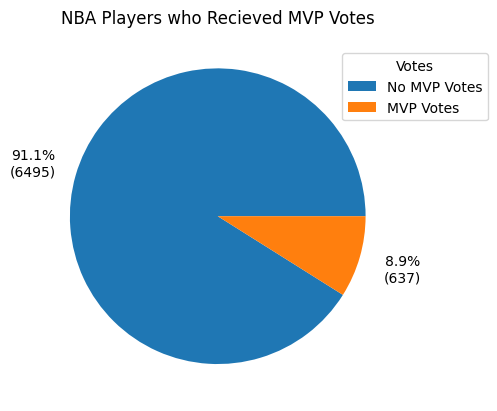

In [ ]:
from collections import Counter
from imblearn.over_sampling import SMOTE

classes = main_df["award_share"] > 0

dataDf = main_df.drop(["player", "pos", "team_id"], axis = 1)
unSmoteLen = len(dataDf)

def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n({:d})".format(pct, absolute)

fig, ax = plt.subplots()

wedges, texts, autotexts = ax.pie(classes.value_counts(),
       autopct = lambda pct: func(pct, classes.value_counts()),
       pctdistance = 1.3)

ax.set_title("NBA Players who Recieved MVP Votes")

ax.legend(["No MVP Votes", "MVP Votes"],
          title="Votes",
          loc = 'center right',
           bbox_to_anchor=(1.25, 0.85))

plt.show()

Our dataset is looking much better, but it is still pretty imbalanced as only 8.9% of the players in our dataset have received MVP votes. To fix this problem we can use SMOTE to oversample over minority class.

SMOTE stands for Synthetic Minority Oversampling TEchnique and it does exactly what the name implies, it creates synthetic samples of the minority class.

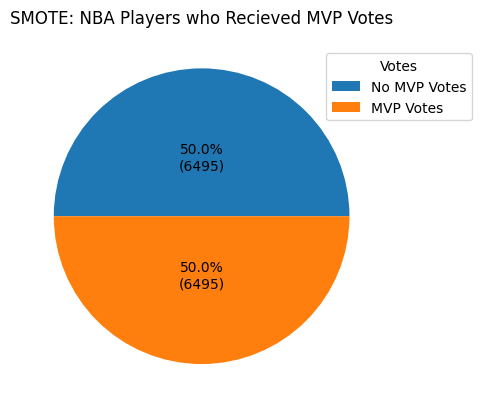

In [ ]:
smote = SMOTE(sampling_strategy = 1)
dataDf, classes = smote.fit_resample(dataDf, classes)

fig, ax = plt.subplots()

wedges, texts, autotexts = ax.pie(classes.value_counts(),
       autopct = lambda pct: func(pct, classes.value_counts()),
       pctdistance = 0.4)

ax.set_title("SMOTE: NBA Players who Recieved MVP Votes")

ax.legend(["No MVP Votes", "MVP Votes"],
          title="Votes",
          loc = 'center right',
           bbox_to_anchor=(1.25, 0.85))

plt.show()

---

### Random Forest Model

The first Random Forest we generated used the SMOTE oversamples that we made before. Both models below will use the features that were selected as 'green' from the Boruta method to create a good sense of which model is better

In [ ]:
green.append('was_mvp')

In [ ]:
# Splitting the Data into X and Y
prelim_df = dataDf[green]
y = prelim_df['was_mvp']
X = prelim_df.drop('was_mvp', axis = 1)

# Splitting the dataframe into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101)

# Fitting the Model
rf = RandomForestClassifier(max_depth = 15)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Print out the Recall of the Model
print("RECALL OF THE MODEL:", metrics.recall_score(y_test, y_pred))
metrics.confusion_matrix(y_test, y_pred)

RECALL OF THE MODEL: 0.678082191780822


array([[2449,    3],
       [  47,   99]])

In [ ]:
param_grid = {
    'n_estimators': [25, 50, 100, 150],
    'max_features': [None],
    'max_depth': [6, 9, 12],
    'max_leaf_nodes': [4, 7, 10],
}

grid_search = GridSearchCV(RandomForestClassifier(),
                           param_grid=param_grid)
grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)

RandomForestClassifier(max_depth=12, max_features=None, max_leaf_nodes=10,
                       n_estimators=25)


In [ ]:
model_grid = RandomForestClassifier(max_depth = 12,
                                    max_features = None,
                                    max_leaf_nodes = None,
                                    n_estimators = 100)
model_grid.fit(X_train, y_train)
y_pred_grid = model_grid.predict(X_test)
print(metrics.classification_report(y_pred_grid, y_test))

metrics.confusion_matrix(y_test, y_pred_grid)

              precision    recall  f1-score   support

       False       1.00      0.98      0.99      2497
        True       0.65      0.94      0.77       101

    accuracy                           0.98      2598
   macro avg       0.82      0.96      0.88      2598
weighted avg       0.98      0.98      0.98      2598



array([[2446,    6],
       [  51,   95]])

Our first model here is not too bad in correctly picking the MVPs, however it is not a great performance either as an approximately 2/3 correct prediction is one that could be improved on

---



The second random forest we created is a base line using our original, unbalanced data set

In [ ]:
fsrf_df = fs_df[green]
fs_y = fsrf_df['was_mvp']
fs_X = fsrf_df.drop('was_mvp', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(fs_X, fs_y, test_size = 0.2, random_state = 101)

rf = RandomForestClassifier(max_depth = 5)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("RECALL OF THE MODEL:", metrics.recall_score(y_test, y_pred))
metrics.confusion_matrix(y_test, y_pred)

RECALL OF THE MODEL: 0.8333333333333334


array([[1454,    0],
       [   2,   10]])

At first glance it may seem like SMOTE negatively affected our model, however this is untrue as the only reason our second model seemingly performs better is due to overfitting. With our max_depth at 5, the second model is still overfit and when exposed to new data performs poorly





---



### XGBoost Model


In [ ]:
dataDf["is_smote"] = dataDf.index >= unSmoteLen
labeledDataDf = dataDf.merge(main_df, how = "left")

Not all stats in the NBA are created equal. For example, assists per game is way less valuable than points per game for predicting the MVP. Many people think more data is better, but this is only true when the data we are adding is useful. If we start adding data that means nothing, like the number of gaterades consumed per game, it won't help our model. Thus we need to "select" the statistics that are most important to our model.

In [ ]:

columns = ['age', 'g', 'gs', 'mp_per_g', 'fga_per_g', 'fg_pct',
        'fg2a_per_g', 'fg2_pct', 'efg_pct', 'fta_per_g', 'ft_pct', 'drb_per_g',
        'ast_per_g', 'stl_per_g', 'tov_per_g', 'pf_per_g', 'pts_per_g', 'mp',
        'per', 'ts_pct', 'fta_per_fga_pct', 'drb_pct', 'trb_pct', 'ast_pct',
        'stl_pct', 'tov_pct', 'usg_pct', 'ows', 'dws', 'ws', 'ws_per_48',
        'obpm', 'dbpm', 'bpm', 'vorp', 'mov', 'win_loss_pct']

pts_cutoff = mvpShares["pts_per_g"].mean() - 3 * mvpShares["pts_per_g"].std()

In [ ]:
dfTestSet = dfTestSet[(dfTestSet["gs"] > 20) & (dfTestSet["pts_per_g"] > pts_cutoff) & (dfTestSet["mp_per_g"] > mp_cutoff)].reset_index(drop = True)

from pandas.core.dtypes.common import validate_all_hashable

# Shuffling the data
modelDf = labeledDataDf.sample(frac=1).reset_index(drop = True)

# Train Data
trainInfo = modelDf[["season", "player", "pos", "team_id","award_share",  "was_mvp", "is_smote"]]
trainData = modelDf[columns]
trainTargets = modelDf[["award_share"]]

# Test Data
testInfo = dfTestSet[["season", "player", "pos", "team_id", "award_share", "was_mvp"]]
testData = dfTestSet[columns]
testTargets = dfTestSet[["award_share"]]

In [ ]:
from xgboost import XGBRegressor

validation_scores = {"season" : [], "mae" : [], "was_mvp" : [], "was_top_two" : [], "was_top_three":[], "info" : []}
seasons = trainInfo.season.unique()

for season in seasons:
  print("\n")
  print(f"Season: {season}")

  trainFold = trainData[trainInfo["season"] != season]
  trainTarFold = trainTargets[trainInfo["season"] != season]
  valFold = trainData[(trainInfo["season"] == season) & (~trainInfo["is_smote"])]
  valTarFold = trainTargets[(trainInfo["season"] == season) & (~trainInfo["is_smote"])]
  valInfo = trainInfo[(trainInfo["season"] == season) & (~trainInfo["is_smote"])]

  regr = XGBRegressor(objective='reg:squarederror', random_state=0, max_depth = 6)
  regr.fit(trainFold, trainTarFold)

  valPred = regr.predict(valFold)
  mae = np.mean(np.absolute(valPred - valTarFold.to_numpy()[:,0]))
  print(f"MAE: {mae}")

  topTwo = valInfo.iloc[np.argsort(valPred)[-2:]]
  was_top_two = sum(topTwo["was_mvp"]) > 0
  topThree = valInfo.iloc[np.argsort(valPred)[-3:]]
  was_top_three = sum(topThree["was_mvp"]) > 0
  print("Predicted top three players in MVP voting with their actual award_share:")
  print(topThree.iloc[::-1])

  mostVotes = np.argmax(valPred)
  score = np.amax(valPred)
  was_mvp = valInfo.iloc[[mostVotes]]["was_mvp"].values[0]
  player = valInfo.iloc[[mostVotes]]["player"].values[0]
  print(f"Predicted MVP: {player}")
  print(f"Predicted Win Share: {score}")
  print(f"Was MVP correct: {was_mvp}")

  validation_scores["season"].append(season)
  validation_scores["mae"].append(mae)
  validation_scores["was_mvp"].append(was_mvp)
  validation_scores["info"].append(valInfo.iloc[[mostVotes]])
  validation_scores["was_top_two"].append(was_top_two)
  validation_scores["was_top_three"].append(was_top_three)



Season: 2000
MAE: 0.006402353259978619
Predicted top three players in MVP voting with their actual award_share:
       season            player pos team_id  award_share  was_mvp  is_smote
5671     2000  Shaquille O'Neal   C     LAL        0.998     True     False
6308     2000     Kevin Garnett  PF     MIN        0.337    False     False
11188    2000       Karl Malone  PF     UTA        0.258    False     False
Predicted MVP: Shaquille O'Neal
Predicted Win Share: 0.9797613024711609
Was MVP correct: True


Season: 2015
MAE: 0.005652314760391823
Predicted top three players in MVP voting with their actual award_share:
       season         player pos team_id  award_share  was_mvp  is_smote
8634     2015  Stephen Curry  PG     GSW        0.922     True     False
10145    2015   James Harden  SG     HOU        0.720    False     False
62       2015   LeBron James  SF     CLE        0.425    False     False
Predicted MVP: Stephen Curry
Predicted Win Share: 0.7017568945884705
Was MVP corre

In [ ]:
print(f"The XGBoost Model predicted the NBA MVP correctly {sum(validation_scores['was_mvp'])/len(seasons)}% of the time")
print(f"The XGBoost Model predicted the NBA MVP correctly in the top two {sum(validation_scores['was_top_two'])/len(seasons)}% of the time")
print(f"The XGBoost Model predicted the NBA MVP correctly in the top three {sum(validation_scores['was_top_three'])/len(seasons)}% of the time")

The XGBoost Model predicted the NBA MVP correctly 0.9% of the time
The XGBoost Model predicted the NBA MVP correctly in the top two 1.0% of the time
The XGBoost Model predicted the NBA MVP correctly in the top three 1.0% of the time


### Conclusions

We were able to use the dataset we chose to create a strong model for predicting the MVPs of each season that has been played in the NBA over the past 40 years.

We found that the most important statistics for determining NBA players are listed below

In [ ]:
print(green)

['fga_per_g', 'fg2a_per_g', 'pts_per_g', 'per', 'ows', 'dws', 'ws', 'ws_per_48', 'obpm', 'bpm', 'vorp', 'award_share', 'mov', 'mov_adj', 'win_loss_pct', 'was_mvp']


The statistics are a combination of base stats, such as field goal attempts per game and points per game, and advanced stats, such as usage percentage, win share, and value over replacement plater (vorp).

We were able to predict very accurately with the xgboost model, a minimum of 80% of the time. We feel these results are very strong and can be replicated with future data in the NBA. As for other sports we feel that a similar method can be followed to determine the MVPs or best players, however complexity would change drastically based on the sport.